In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.mixture import GaussianMixture
from pathlib import Path
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [42]:
# set wd
os.chdir((Path.home()/"wdpath.txt").read_text().strip())

In [4]:
# load data
with open("processed-data/003-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

### Cluster PCs and PCAs with GMM

In [5]:
print(dat_dict['rDims']["PCA"]['scores'].shape)
print(dat_dict['rDims']["PCA"]['scores'].shape)

(12460, 50)
(12460, 50)


In [6]:
PC_df = (
    pd.DataFrame(dat_dict['rDims']["PCA"]['scores'][:,:3])
    .assign(tissue = dat_dict['colData'].SMTS.values)
)

NMF_df = (
    pd.DataFrame(dat_dict['rDims']["NMF"]['scores'][:,:3])
    .assign(tissue = dat_dict['colData'].SMTS.values)
)

### plot tissues on dims

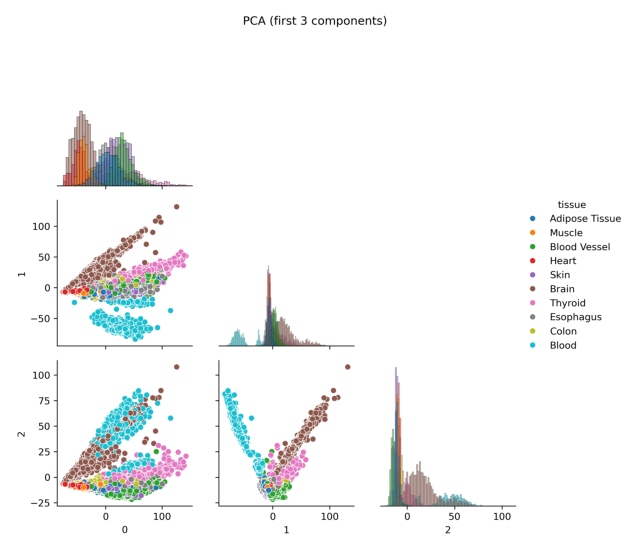

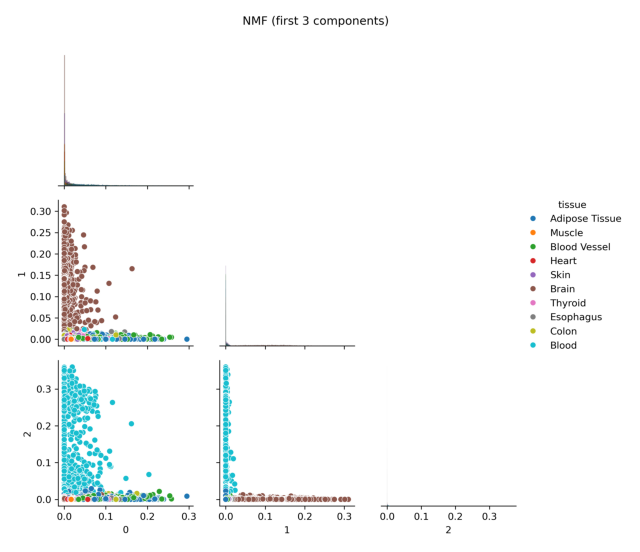

10 unique tissues


In [7]:

if False:
    p1 = sns.PairGrid(PC_df, hue="tissue", corner=True, 
                vars=PC_df.columns[:3])
    p1.map_lower(sns.scatterplot)
    p1.map_diag(sns.histplot)
    p1.map_upper(sns.scatterplot)
    p1.add_legend()
    p1.figure.suptitle("PCA (first 3 components)", y=1.02)

    # Save PCA figure
    p1.figure.savefig("results/tissue-pca-pairs.png", dpi=300, bbox_inches="tight")
    plt.close(p1.figure)   


    p2 = sns.PairGrid(NMF_df, hue="tissue", corner=True,
                vars=NMF_df.columns[:3])
    p2.map_lower(sns.scatterplot)
    p2.map_diag(sns.histplot)
    p2.map_upper(sns.scatterplot)
    p2.add_legend()
    p2.figure.suptitle("NMF (first 3 components)", y=1.02)

    p2.figure.savefig("results/tissue-nmf-pairs.png", dpi=300, bbox_inches="tight")
    plt.close(p2.figure)  
else:
    p1 = mpimg.imread("results/tissue-pca-pairs.png")
    p2 = mpimg.imread("results/tissue-nmf-pairs.png")

    plt.figure(figsize=(8, 8))
    plt.imshow(p1)
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.imshow(p2)
    plt.axis("off")
    plt.show()

print(f"{len(dat_dict['colData'].SMTS.unique())} unique tissues")

#### find best component number

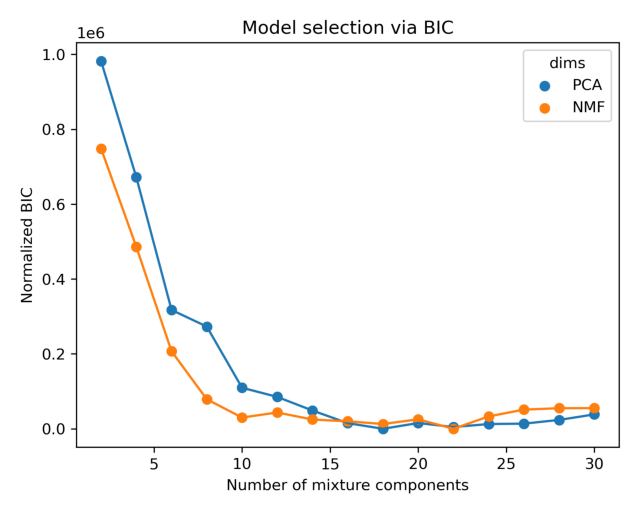

In [8]:

if False:
    for dim in ['PCA','NMF']:
        res = []
        for i in range(2, 32,2):
            gmm = GaussianMixture(n_components=i, random_state=0)
            gmm.fit(dat_dict['rDims'][dim]['scores'])
            BIC = gmm.bic(dat_dict['rDims'][dim]['scores'])
            res.append({"i": i, "BIC": BIC})
            
        res = pd.DataFrame(res)
        res['BIC'] = res['BIC'] - res['BIC'].min()
        
        plt.scatter(res['i'], res['BIC'], label = dim)
        # connect points with a line
        plt.plot(res['i'], res['BIC'])

    plt.legend(title="dims")
    plt.xlabel("Number of mixture components")
    plt.ylabel("Normalized BIC")
    plt.title("Model selection via BIC")

    # SAVE 
    plt.savefig("results/dims-gmm-bics.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close() 

else:
    p = mpimg.imread("results/dims-gmm-bics.png")
    plt.figure(figsize=(8, 8))
    plt.imshow(p)
    plt.axis("off")
    plt.show()
    



NMF components for two components have best BIC relative to PCA

#### Cluster on NMF Components

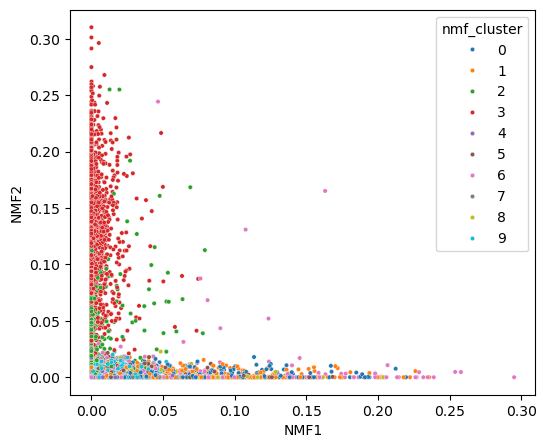

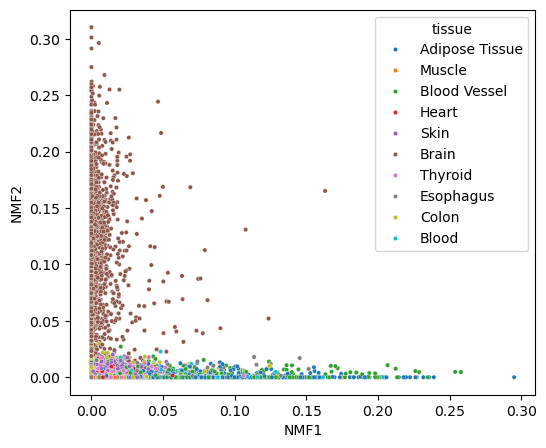

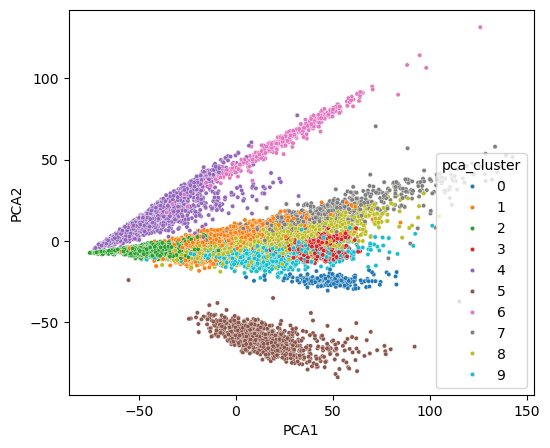

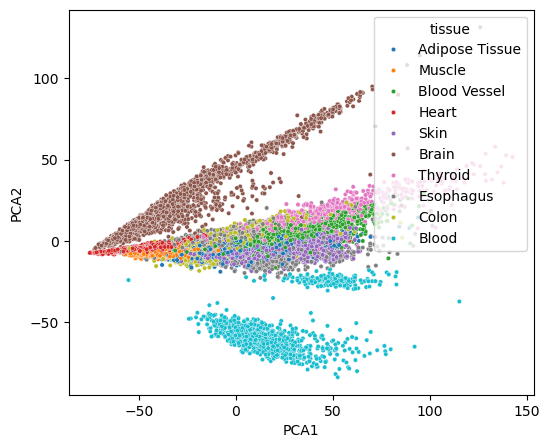

In [9]:

# make model object
np.random.seed(1293)
NMF_gmm= GaussianMixture(n_components= 10,random_state=0) 
PCA_gmm= GaussianMixture(n_components= 10,random_state=0) 

# fit model
NMF_gmm.fit(dat_dict['rDims']['NMF']['scores'])
PCA_gmm.fit(dat_dict['rDims']['PCA']['scores'])

# predict clusters from data
NMF_clusters = NMF_gmm.predict(dat_dict['rDims']['NMF']['scores'])
PCA_clusters = PCA_gmm.predict(dat_dict['rDims']['PCA']['scores'])

nmf = pd.DataFrame(
    dat_dict['rDims']["NMF"]["scores"],
    columns=[f"NMF{i+1}" for i in range(dat_dict['rDims']['NMF']['scores'].shape[1])]
)

pca = pd.DataFrame(
    dat_dict['rDims']["PCA"]["scores"],
    columns=[f"PCA{i+1}" for i in range(dat_dict['rDims']['PCA']['scores'].shape[1])]
)

plot_df = pd.concat([nmf, pca], axis=1).assign(
    nmf_cluster=NMF_clusters,
    pca_cluster=PCA_clusters,
    tissue = dat_dict['colData'].SMTS.values
)

plot_df["nmf_cluster"] = plot_df["nmf_cluster"].astype("category")
plot_df["pca_cluster"] = plot_df["pca_cluster"].astype("category")


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="NMF1", y="NMF2",
    hue="nmf_cluster",
    s=10
)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="NMF1", y="NMF2",
    hue="tissue",
    s=10
)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="PCA1", y="PCA2",
    hue="pca_cluster",
    # palette= palette    
    s=10
)
plt.show()


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="PCA1", y="PCA2",
    hue="tissue",
    s=10
)
plt.show()



<Figure size 400x400 with 0 Axes>

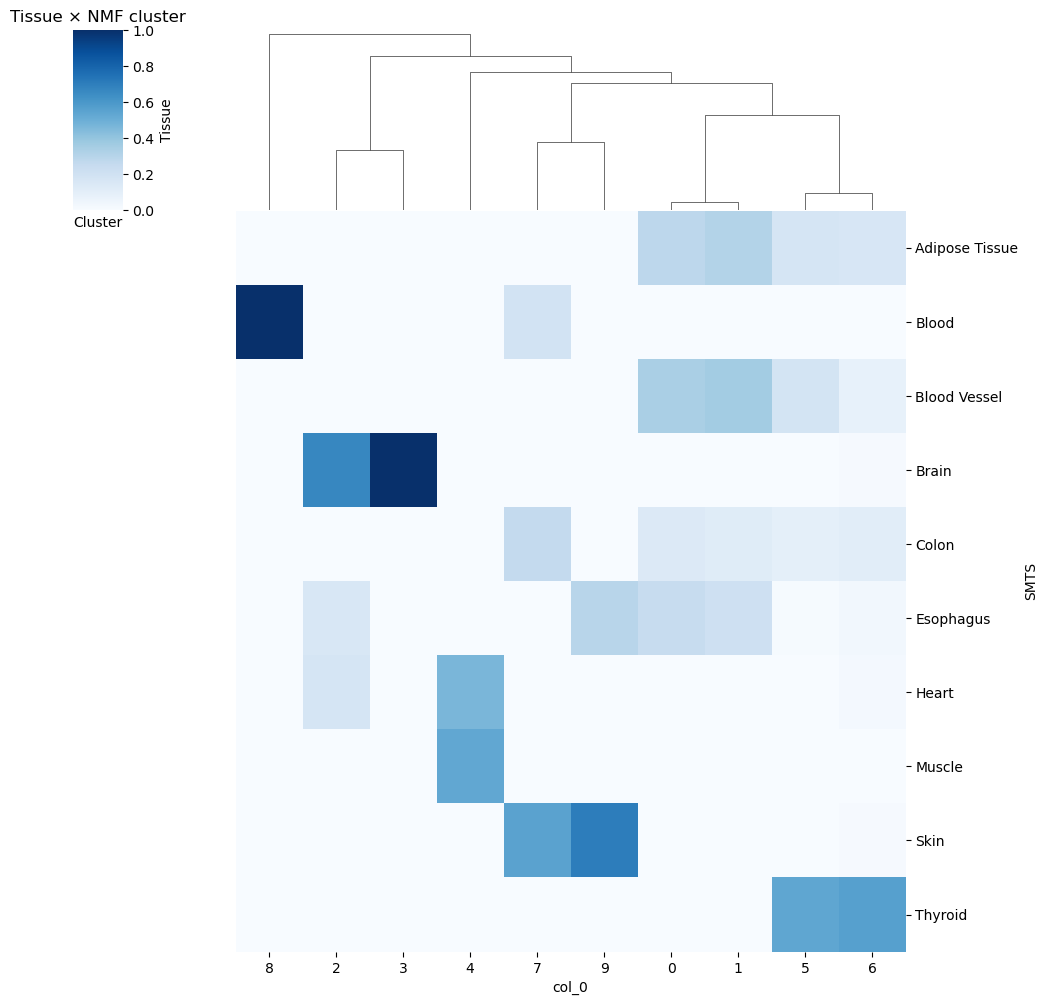

<Figure size 400x400 with 0 Axes>

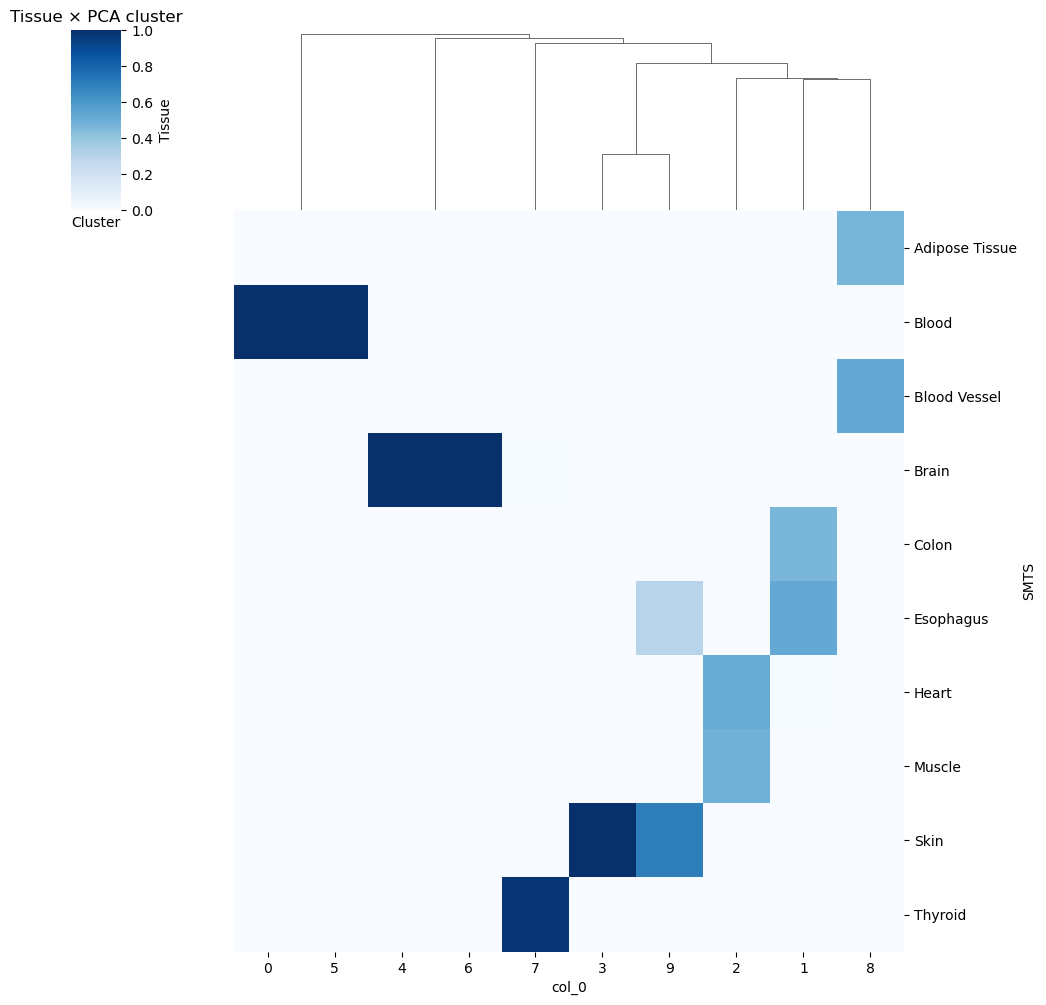

In [41]:
tab = pd.crosstab(dat_dict['colData'].SMTS, NMF_clusters)
tab = tab /tab.sum()

plt.figure(figsize=(4,4))
sns.clustermap(tab, annot=False, cmap="Blues", row_cluster=False)
plt.title("Tissue × NMF cluster")
plt.xlabel("Cluster")
plt.ylabel("Tissue")
plt.show()

tab = pd.crosstab(dat_dict['colData'].SMTS, PCA_clusters)
tab = tab /tab.sum()

plt.figure(figsize=(4,4))
sns.clustermap(tab, annot=False, cmap="Blues",row_cluster=False)
plt.title("Tissue × PCA cluster")
plt.xlabel("Cluster")
plt.ylabel("Tissue")
plt.show()

In [ ]:
# from sklearn.metrics import classification_report

# y_true = dat_dict['colData']['SMTS'].values

# print("\\\\ NMF GMM classification Report \\\\\n",classification_report(y_true, NMF_clusters, zero_division=0))
# print("\\\\ PCA GMM classification Report \\\\\n",classification_report(y_true, PCA_clusters, zero_division=0))

Classification on PCA works better because clusters have more unique tissues